# PS6 Solutions

## Part 1

### Problem 1

In [13]:
import seaborn as sns
import pandas as pd
import numpy as np

import sklearn.datasets
import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.pipeline
import sklearn.model_selection
import sklearn.metrics

import torch
import skorch

### Problem 2

In [14]:
bunch_nasa = sklearn.datasets.fetch_openml(
    data_id=42821,
    as_frame=True,
    parser='auto'
)

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


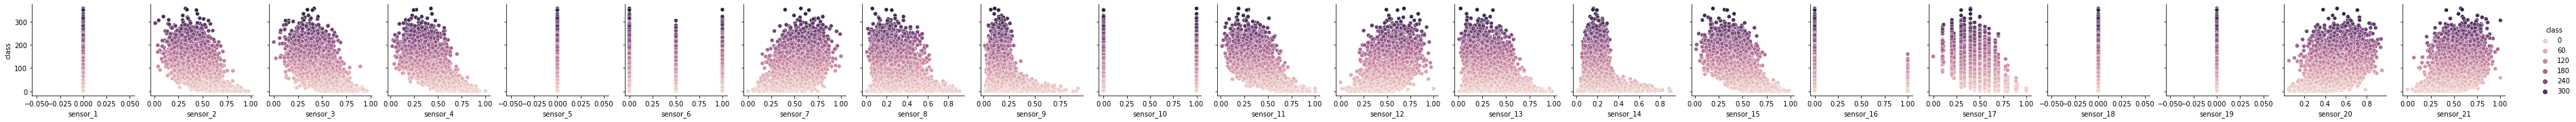

In [15]:
sns.pairplot(
    data=bunch_nasa.frame.sample(frac=0.1),
    y_vars="class",
    hue="class"
)

sensor_1, sensor_5, sensor_6, sensor_10, sensor_16, sensor_18, sensor_19 all look like they aren't helpful.

Nothing looks linear, unfortunately.  The output might be nonlinear.  We can check how many samples we have of the targets with a histogram of the target as well:

<Axes: xlabel='class', ylabel='Count'>

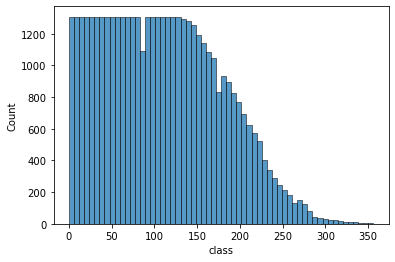

In [16]:
sns.histplot(data=bunch_nasa.target)

Looks like we will have a bit of an imbalance with the training set.  We may want to selectively subsample so that the upper end doesn't get lost, see: https://stats.stackexchange.com/questions/575378/stratification-of-the-continuous-y-target-variable-in-regression-setting

In [17]:
np.any(bunch_nasa.data.isna())  # check for malformed rows.

False

### Problem 3

In [18]:
import importlib
import ps6_funcs as ps6f
importlib.reload(ps6f)

<module 'ps6_funcs' from 'C:\\Users\\Agonz\\Downloads\\EE5830\\week09\\ps6_funcs.py'>

### Problem 4

To try to get a better pattern, I'll try to make the data be about the same flat histogram, meaning that any target values lower than 250 will be reduced to just 200 samples each bin.  It's about 8 bins for every 50, so we'll have 40 bins to choose from for everything less than 250.  That comes to about 40 bins * 200 samples per bin, which is a sample size of 8000.

My pipeline will just include some sort of scaling to shift the mean/median to 0.0, and selectkbest for the top 6 features.

In [19]:
df_nasa_clean_lower = bunch_nasa.frame[bunch_nasa.frame["class"] < 250].sample(n=32*200)
df_nasa_clean_full = pd.concat([
        df_nasa_clean_lower, 
        bunch_nasa.frame[bunch_nasa.frame["class"] >= 250]
    ]).drop(
        columns=["sensor_1", "sensor_5", "sensor_6", "sensor_10", "sensor_16", "sensor_18", "sensor_19"])
df_nasa_clean_full.describe()

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,class
count,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000,7521.000000
mean,0.440109,0.434932,0.419342,0.534494,0.260117,0.177600,0.408741,0.529883,0.271978,0.201937,0.437609,0.451952,0.519501,0.534752,129.445951
std,0.142207,0.137379,0.155449,0.146452,0.149360,0.098405,0.164232,0.149083,0.160813,0.093982,0.156087,0.151929,0.149711,0.143388,84.664996
min,0.000000,0.023903,0.000000,0.000000,0.000000,0.000000,0.000000,0.032609,0.000000,0.000000,0.000000,0.000000,0.000000,0.020255,0.000000
25%,0.340909,0.342525,0.308014,0.436620,0.158940,0.120070,0.289655,0.431250,0.158537,0.148511,0.326573,0.333333,0.419355,0.439759,59.000000
50%,0.431818,0.426344,0.402313,0.538732,0.218241,0.158895,0.390411,0.533333,0.223214,0.186313,0.422247,0.444444,0.522222,0.536970,119.000000
75%,0.530303,0.517986,0.514656,0.636620,0.321429,0.204658,0.506667,0.635193,0.348243,0.231373,0.533740,0.555556,0.623656,0.635183,188.000000
max,1.000000,0.931115,0.965378,1.000000,0.941368,1.000000,1.000000,0.978541,0.982759,0.971734,0.986939,1.000000,1.000000,1.000000,356.000000


<Axes: xlabel='class', ylabel='Count'>

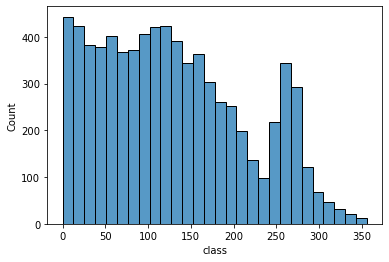

In [20]:
sns.histplot(data=df_nasa_clean_full["class"])

It's not a perfect subsample, but it's better than it was before.

In [21]:
nasa_X_train, nasa_X_test, nasa_y_train, nasa_y_test = sklearn.model_selection.train_test_split(
    df_nasa_clean_full.drop(columns=["class"]), 
    df_nasa_clean_full["class"], 
    test_size=0.3, 
    random_state=7
)

In [22]:
desired_features = 6

nasa_torch_pipeline_steps = [
    ("selector", sklearn.feature_selection.SelectKBest(
        score_func=sklearn.feature_selection.mutual_info_regression,
        k=desired_features
    )),
    ("scaler", sklearn.preprocessing.RobustScaler()),
    ("estimator", skorch.NeuralNetRegressor(
        ps6f.PS6RegressorModule,
        optimizer=torch.optim.Adam,
        lr=0.4,
        max_epochs=50,
        callbacks=[skorch.callbacks.EarlyStopping(
            patience=10)],
        batch_size=200,
    ))
]

nasa_torch_pipeline = sklearn.pipeline.Pipeline(nasa_torch_pipeline_steps)

In [23]:
nasa_torch_pipeline["estimator"].module__n_input_features = desired_features
nasa_torch_pipeline["estimator"].module__dense_layer_sizes = (30, 30,)

In [24]:
nasa_X_train.to_numpy().dtype

dtype('float64')

In [25]:
nasa_y_train.values.dtype

dtype('float64')

In [26]:
nasa_X_train.astype('float32').describe()

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
count,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000
mean,0.440295,0.435356,0.420734,0.533499,0.259387,0.178188,0.410812,0.529898,0.271365,0.202328,0.438240,0.453331,0.518191,0.536159
std,0.142626,0.136399,0.155516,0.145129,0.149495,0.098966,0.163612,0.148737,0.161592,0.094812,0.155106,0.151254,0.149525,0.142798
min,0.000000,0.029389,0.000000,0.000000,0.000000,0.000000,0.020690,0.037528,0.000000,0.009493,0.000399,0.000000,0.000000,0.065830
25%,0.340909,0.343569,0.308183,0.435673,0.156352,0.120155,0.293333,0.431159,0.156550,0.148213,0.326797,0.333333,0.419355,0.440992
50%,0.432927,0.427776,0.403735,0.537975,0.215873,0.158518,0.393103,0.533333,0.222222,0.185841,0.423405,0.444444,0.517241,0.537955
75%,0.530547,0.517570,0.515935,0.636148,0.321429,0.205653,0.506667,0.634137,0.345238,0.231518,0.535850,0.555556,0.622222,0.636679
max,1.000000,0.909724,0.965378,1.000000,0.892857,1.000000,1.000000,0.971014,0.982759,0.971734,0.955594,1.000000,0.979381,0.958308


In [27]:
nasa_X_train.describe()

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
count,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000,5264.000000
mean,0.440295,0.435356,0.420734,0.533499,0.259387,0.178188,0.410812,0.529898,0.271365,0.202328,0.438240,0.453331,0.518191,0.536159
std,0.142626,0.136399,0.155516,0.145129,0.149495,0.098966,0.163612,0.148737,0.161592,0.094812,0.155106,0.151254,0.149525,0.142798
min,0.000000,0.029389,0.000000,0.000000,0.000000,0.000000,0.020690,0.037528,0.000000,0.009493,0.000399,0.000000,0.000000,0.065830
25%,0.340909,0.343569,0.308183,0.435673,0.156352,0.120155,0.293333,0.431159,0.156550,0.148213,0.326797,0.333333,0.419355,0.440992
50%,0.432927,0.427776,0.403735,0.537975,0.215873,0.158518,0.393103,0.533333,0.222222,0.185841,0.423405,0.444444,0.517241,0.537955
75%,0.530547,0.517570,0.515935,0.636148,0.321429,0.205653,0.506667,0.634137,0.345238,0.231518,0.535850,0.555556,0.622222,0.636679
max,1.000000,0.909724,0.965378,1.000000,0.892857,1.000000,1.000000,0.971014,0.982759,0.971734,0.955594,1.000000,0.979381,0.958308


### Problem 5, 6, 7

TIP: Remember, if you run into errors, you should re-run the pipeline creation cell to re-initialize everything after you fix the issue in the module.

ANOTHER TIP: Remember, both x and y must be 2D arrays -- meaning that we need to reshape y!

In [28]:
nasa_torch_pipeline.fit(nasa_X_train.to_numpy().astype('float32'), nasa_y_train.values.astype('float32').reshape(-1,1))

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     5757.5944     3333.3090  0.4104
      2     3483.8342     3494.9248  0.2571
      3     3506.4317     3298.6889  0.2470
      4     3691.5601     3672.1391  0.2389
      5     3323.0402     3319.7193  0.1523
      6     3380.3064     3439.3818  0.1497
      7     3335.8413     3345.2057  0.1466
      8     3360.1257     3432.0571  0.1468
      9     3345.4293     3399.0185  0.1489
     10     3332.6795     3396.7020  0.1364
     11     3341.5752     3395.3049  0.1484
     12     3309.6376     3369.0518  0.1353
Stopping since valid_loss has not improved in the last 10 epochs.


Pipeline(steps=[('selector',
                 SelectKBest(k=6,
                             score_func=<function mutual_info_regression at 0x0000021A50F33B50>)),
                ('scaler', RobustScaler()),
                ('estimator',
                 <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=PS6RegressorModule(
    (dense_network): ModuleList(
      (0): Linear(in_features=6, out_features=30, bias=True)
      (1): Linear(in_features=30, out_features=30, bias=True)
    )
    (output): Linear(in_features=30, out_features=1, bias=True)
  ),
))])

In [29]:
nasa_torch_pipeline.score(nasa_X_test.to_numpy().astype('float32'), nasa_y_test.values.astype('float32'))

0.5191214254768408

In [30]:
nasa_y_pred = nasa_torch_pipeline.predict(nasa_X_test.to_numpy().astype('float32'))

In [31]:
nasa_y_pred.shape

(2257, 1)

<Axes: ylabel='class'>

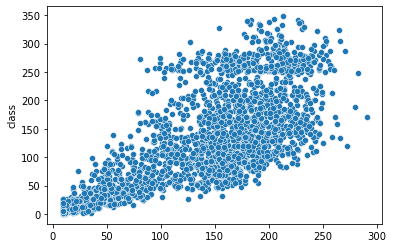

In [32]:
sns.scatterplot(y=nasa_y_test, x=nasa_y_pred[:,0])

In [33]:
sklearn.metrics.mean_absolute_error(y_true=nasa_y_test, y_pred=nasa_y_pred[:,0])

45.93961376060043

In [34]:
nasa_torch_pipeline["estimator"].module_.dense_network[0].weight, nasa_torch_pipeline["estimator"].module_.dense_network[0].bias

(Parameter containing:
 tensor([[-1.9407,  0.8760, -1.2867, -0.2581,  0.4141,  0.0709],
         [ 0.6648, -0.0362,  0.1981, -0.7756,  0.1036,  0.4831],
         [-0.9956, -1.1662, -1.7411, -2.3063, -1.0278, -2.0433],
         [ 0.2136, -0.5519, -0.2521, -0.1802, -0.2330,  0.0670],
         [ 0.8069, -1.2680, -0.1833,  0.4901,  0.4519, -0.9145],
         [-0.0855, -0.9753, -0.4934, -0.9811, -0.9219,  0.1962],
         [ 0.9213, -0.0439,  2.0157, -0.1803,  1.1132,  1.3414],
         [ 1.0857, -1.6323,  0.3102, -1.8320,  1.3375,  1.0507],
         [ 1.7320,  0.1914,  1.4855,  1.9511,  1.0709, -2.2842],
         [ 1.2650,  0.0112,  1.4347, -0.6118,  0.2932,  0.0745],
         [ 0.5425,  2.6243, -0.5574, -1.7496, -2.0573,  2.1751],
         [ 0.0766, -0.5132, -0.2221, -0.4099,  0.3659,  0.0666],
         [ 1.5533, -0.9620, -0.4681, -0.6683, -0.4497, -0.5428],
         [ 0.1725, -0.3600, -0.2419, -0.1777,  0.1647,  0.8425],
         [ 0.0461, -0.7613, -0.0073, -0.4440,  0.0269,  0.0429],
  

In [35]:
nasa_torch_pipeline["estimator"].module_.dense_network[1].weight, nasa_torch_pipeline["estimator"].module_.dense_network[1].bias

(Parameter containing:
 tensor([[-2.5831e+00, -2.5199e+00, -2.4247e+00, -2.3084e+00, -2.2511e+00,
          -2.5174e+00, -2.2601e+00, -2.2484e+00, -2.4681e-02, -2.5351e+00,
          -2.5405e+00, -2.5105e+00, -2.3738e+00, -2.3961e+00, -2.2689e+00,
          -1.0329e-01, -2.3185e+00,  1.1775e-01, -2.3731e+00, -2.3207e+00,
          -2.5608e+00, -2.4000e+00, -2.5367e+00, -2.5343e+00, -2.4045e+00,
          -2.2919e+00, -2.4144e+00, -2.5233e+00, -2.3225e+00, -2.4857e+00],
         [-2.2854e+00, -2.4774e+00, -2.4259e+00, -2.3980e+00, -2.5553e+00,
          -2.2707e+00, -2.2887e+00, -2.2990e+00, -2.4405e+00, -2.5236e+00,
          -2.3416e+00, -2.2556e+00, -2.5437e+00, -2.3090e+00, -2.3663e+00,
          -2.4207e+00, -2.2679e+00, -2.5525e+00, -2.5033e+00, -2.2377e+00,
          -2.3497e+00, -2.4112e+00, -2.4847e+00, -2.3592e+00, -2.2873e+00,
          -2.5768e+00, -2.3431e+00, -2.2820e+00, -2.5627e+00, -2.2535e+00],
         [-2.4434e+00, -2.3339e+00, -2.2369e+00, -2.4925e+00, -2.2703e+00,


The PyTorch implementation is a little bit better for the (30, 30) hidden layer shapes than the sklearn implementation.  Luckily we still get only positive values.

## Part 2

For part 2, just follow PS5 but use your torch module with `skorch`'s `NeuralNetRegressor` as the estimator.

In [75]:
nasa_net_pipeline_steps = [
    ("selector", sklearn.feature_selection.SelectKBest(
        score_func=sklearn.feature_selection.mutual_info_regression,
        k=6
    )),
    ("scaler", sklearn.preprocessing.RobustScaler()),
    ("estimator", skorch.NeuralNetRegressor(
        ps6f.PS6RegressorModule,
        optimizer=torch.optim.Adam,
        lr=0.4,
        max_epochs=50,
        callbacks=[skorch.callbacks.EarlyStopping(
            patience=10)],
        batch_size=200,
    ))
]

nasa_net_pipeline = sklearn.pipeline.Pipeline(nasa_net_pipeline_steps)

In [80]:
nasa_net_pipeline["estimator"].module__n_input_features = desired_features
nasa_net_pipeline["estimator"].module__dense_layer_sizes = (30, 30,)

In [87]:
param_grid = {
    "estimator__module__dense_layer_sizes": (
        (26, 26,),
        (30, 30,),
        (10, 10,),
        (26, 26, 26,),
        (30, 30, 30,),
        (10, 10, 10,),
        (30, 26, 10,),
    ),
}

In [88]:
nasa_net_cv = sklearn.model_selection.GridSearchCV(
    nasa_net_pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    #n_jobs=2,
    verbose=3,
    return_train_score=True
)

In [89]:
nasa_net_cv.fit(nasa_X_train.to_numpy().astype('float32'), nasa_y_train.values.astype('float32').reshape(-1,1))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     7889.6843     3890.9273  0.2120
      2     3442.3393     3431.9160  0.2241
      3     3585.5177     3614.5293  0.2031
      4     3654.8206     3151.9328  0.1473
      5     3323.0384     3161.0826  0.1227
      6     3340.3474     3187.2540  0.1282
      7     3400.3408     3201.8651  0.1343
      8     3417.9507     3206.9219  0.1225
      9     3404.0353     3194.7895  0.1194
     10     3383.3248     3215.2440  0.1202
     11     3379.9367     3209.8139  0.1208
     12     3374.5036     3213.2084  0.1262
     13     3364.7522     3213.8739  0.1403
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(26, 26);, score=(train=-43.673, test=-44.260) total time=   3.0s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6356.7334     3420.4745  0.2389
      2     3616.5249     3952.0755  0.2263
      3     3808.9258     3675.9669  0.1993
      4     3707.1690     3386.2605  0.1948
      5     3292.6276     3351.7811  0.1868
      6     3433.9766     3328.5707  0.1748
      7     3431.6880     3320.3384  0.1334
      8     3415.5432     3343.9794  0.1275
      9     3429.8761     3343.9413  0.1145
     10     3414.8392     3336.6855  0.1087
     11     3403.9380     3309.7450  0.1249
     12     3381.8113     3318.5806  0.1355
     13     3384.9301     3319.4649  0.1173
     14     3352.1952     3316.0672  0.1286
     15     3342.7933     3304.1675  0.1181
     16     3327.2290     3328.6593  0.1306
     17     3326.7092     3316.1797  0.1209
     18     3301.2132     3354.2945  0.1207
     19     3355.6365     3312.3023  0.1310
     20     3315.5013     3332.8251  0.1236
     21     3280.4183     3338.2

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6318.6111     3492.0037  0.2521
      2     3453.3328     3317.7186  0.2422
      3     3241.8257     3298.6307  0.1974
      4     3280.9971     3293.1444  0.1840
      5     3263.3147     3307.9412  0.1685
      6     3246.0105     3301.6135  0.1583
      7     3243.9947     3311.2061  0.1141
      8     3249.6949     3302.4502  0.1163
      9     3243.8629     3311.6294  0.1187
     10     3243.8349     3296.3399  0.1161
     11     3226.1077     3317.3828  0.1153
     12     3227.6828     3303.3372  0.1107
     13     3211.5407     3305.0619  0.1146
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/5] END estimator__module__dense_layer_sizes=(26, 26);, score=(train=-43.145, test=-45.704) total time=   2.7s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    17694.7214     5642.0224  0.2440
      2     5044.7799     5018.9044  0.2161
      3     3758.6424     3371.1991  0.2032
      4     3314.5603     3264.6610  0.1907
      5     3243.8824     3250.7880  0.1584
      6     3217.9317     3249.4968  0.1376
      7     3226.9632     3252.8132  0.1341
      8     3237.5221     3259.8653  0.1108
      9     3245.4549     3267.4947  0.1139
     10     3250.5212     3271.2991  0.1081
     11     3251.4816     3279.1589  0.1040
     12     3249.1073     3291.1895  0.1075
     13     3246.0555     3305.2173  0.1187
     14     3250.5928     3325.8879  0.1058
     15     3251.2261     3340.0186  0.1176
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] END estimator__module__dense_layer_sizes=(26, 26);, score=(train=-44.067, test=-42.921) total time=   3.0s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6456.5732     4088.2732  0.2440
      2     3478.4687     3415.2338  0.2702
      3     3463.2076     3784.6545  0.2430
      4     3535.1159     3545.6679  0.2122
      5     3408.0796     3251.0702  0.1967
      6     3291.3277     3332.6091  0.1599
      7     3344.8309     3465.6399  0.1151
      8     3406.7543     3437.2761  0.1254
      9     3363.5897     3328.7552  0.1195
     10     3295.3400     3316.0572  0.1185
     11     3297.2835     3372.9829  0.1123
     12     3305.5944     3366.0561  0.1124
     13     3304.6744     3392.2592  0.1178
     14     3298.1377     3350.5937  0.1234
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(26, 26);, score=(train=-44.215, test=-44.211) total time=   2.8s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    12310.5295     3709.8269  0.1260
      2     3669.7436     3388.6729  0.2190
      3     3329.9828     3206.4931  0.1870
      4     3326.4458     3152.6039  0.1921
      5     3307.8460     3134.7666  0.1982
      6     3330.2369     3124.3952  0.1443
      7     3331.9433     3126.1431  0.1695
      8     3328.3064     3129.4102  0.1076
      9     3317.6648     3130.4324  0.1082
     10     3305.2511     3134.6243  0.1059
     11     3302.9669     3140.4474  0.1114
     12     3301.2548     3141.3495  0.1087
     13     3298.8021     3144.7603  0.1084
     14     3300.7451     3152.4379  0.1001
     15     3296.6553     3152.8939  0.1165
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(30, 30);, score=(train=-43.716, test=-44.315) total time=   2.6s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    10203.0142     3691.9305  0.2481
      2     3738.0372     3297.7851  0.2721
      3     3273.1887     3331.4959  0.2103
      4     3301.2597     3315.8524  0.1850
      5     3309.2094     3308.3904  0.1852
      6     3275.9865     3299.2165  0.1782
      7     3297.6353     3302.6477  0.1049
      8     3304.9835     3291.9536  0.1084
      9     3331.6334     3294.5892  0.1083
     10     3349.5615     3283.0571  0.1145
     11     3352.7722     3297.3271  0.1124
     12     3368.3826     3293.9443  0.1126
     13     3360.0825     3290.5194  0.1120
     14     3359.2718     3293.3459  0.1098
     15     3355.8896     3293.4734  0.1185
     16     3341.3204     3294.0989  0.1085
     17     3338.1887     3283.9800  0.1146
     18     3324.7749     3291.0496  0.1442
     19     3321.4809     3282.7701  0.1285
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/5] E

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    10532.5188     5838.4090  0.2558
      2     4135.7755     4104.7459  0.2512
      3     3395.7947     3630.2627  0.1962
      4     3266.7369     3452.2473  0.1908
      5     3205.8051     3366.1772  0.1775
      6     3181.1710     3343.8449  0.1893
      7     3154.8304     3338.4817  0.1213
      8     3162.9782     3343.7722  0.1127
      9     3158.1747     3356.7686  0.1128
     10     3179.5090     3372.8230  0.1103
     11     3189.2747     3385.6319  0.1085
     12     3186.7004     3396.2543  0.1128
     13     3201.4025     3353.0766  0.1041
     14     3170.2935     3357.3190  0.1009
     15     3172.4510     3346.3592  0.1064
     16     3166.9847     3360.8540  0.1064
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/5] END estimator__module__dense_layer_sizes=(30, 30);, score=(train=-42.835, test=-45.740) total time=   3.0s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     8014.1175     4000.3414  0.2734
      2     3462.5285     3734.8409  0.2150
      3     3664.9996     4360.9381  0.1885
      4     3651.5162     3282.9206  0.1997
      5     3337.7025     3415.4625  0.1746
      6     3409.1546     3627.6712  0.1568
      7     3494.8520     3620.8687  0.1187
      8     3496.7459     3484.5454  0.1308
      9     3423.4315     3498.7719  0.1147
     10     3405.1425     3511.8771  0.1085
     11     3407.9641     3532.9057  0.1076
     12     3409.2306     3496.2601  0.1170
     13     3385.2096     3487.6221  0.1016
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] END estimator__module__dense_layer_sizes=(30, 30);, score=(train=-45.091, test=-43.686) total time=   2.6s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    14912.3016    10150.7015  0.1640
      2     5376.2891     4319.4861  0.1346
      3     3627.8480     3403.4682  0.1603
      4     3262.3506     3279.8011  0.1543
      5     3186.8154     3231.0012  0.1361
      6     3168.2715     3225.2169  0.1427
      7     3164.9748     3226.1075  0.1579
      8     3165.5494     3225.3194  0.1523
      9     3166.9406     3226.6144  0.1038
     10     3169.4032     3231.5806  0.1094
     11     3171.2240     3232.9650  0.1068
     12     3171.3494     3233.3377  0.1058
     13     3172.9201     3233.1212  0.1046
     14     3172.5557     3236.3816  0.1028
     15     3178.3598     3237.6528  0.1170
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(30, 30);, score=(train=-43.261, test=-43.326) total time=   2.5s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     9547.8006     3737.6203  0.2287
      2     3662.6799     3466.6505  0.2257
      3     3424.8231     3288.2428  0.2204
      4     3324.1213     3192.1318  0.2443
      5     3296.4908     3144.3099  0.1705
      6     3298.5820     3111.3559  0.1597
      7     3288.6058     3122.7954  0.1711
      8     3269.9363     3126.0883  0.1836
      9     3256.4566     3130.0090  0.1511
     10     3257.4931     3123.9450  0.1291
     11     3263.6191     3123.3035  0.1068
     12     3262.5186     3129.6333  0.1083
     13     3267.4925     3144.8812  0.1110
     14     3270.7661     3132.1622  0.1083
     15     3270.6918     3136.4458  0.1118
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(10, 10);, score=(train=-43.253, test=-43.603) total time=   3.1s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     8806.3072     4053.6676  0.2170
      2     3424.9554     3268.6538  0.2388
      3     3290.7882     3254.0255  0.2077
      4     3322.5995     3254.3327  0.1671
      5     3309.9265     3259.0836  0.1754
      6     3323.3712     3263.7079  0.1287
      7     3328.1745     3262.4994  0.1356
      8     3327.2512     3267.5118  0.1963
      9     3329.4746     3266.5468  0.1327
     10     3327.3575     3264.6678  0.1475
     11     3324.6738     3259.7661  0.1189
     12     3323.4998     3266.5836  0.1196
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/5] END estimator__module__dense_layer_sizes=(10, 10);, score=(train=-43.524, test=-43.198) total time=   2.6s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     9501.6132     3585.2994  0.2227
      2     3659.4930     3863.1903  0.2230
      3     3417.7646     3421.1165  0.2062
      4     3243.2295     3425.5549  0.1911
      5     3236.7116     3465.0040  0.1850
      6     3253.8039     3452.7362  0.1553
      7     3265.3399     3465.5027  0.1744
      8     3276.7865     3445.1994  0.1126
      9     3248.0255     3294.6807  0.1105
     10     3185.4058     3293.3353  0.1147
     11     3194.3772     3303.1574  0.1065
     12     3207.0899     3284.7321  0.1105
     13     3205.1031     3304.5286  0.1135
     14     3220.7276     3312.0390  0.1136
     15     3228.6058     3281.1658  0.1116
     16     3206.4785     3289.5258  0.1042
     17     3227.9512     3292.0950  0.1170
     18     3229.7984     3290.2142  0.1091
     19     3243.1841     3295.6055  0.1027
     20     3243.6975     3296.1543  0.1112
     21     3236.0920     3288.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    11084.2701     5390.5454  0.2137
      2     4022.8777     3401.8975  0.2144
      3     3394.6787     3335.9817  0.2179
      4     3280.9404     3288.8853  0.1931
      5     3252.2189     3307.3662  0.2326
      6     3246.3856     3332.8785  0.1906
      7     3247.9203     3337.2093  0.2085
      8     3240.4170     3328.2305  0.1745
      9     3238.6202     3320.0879  0.1792
     10     3238.3023     3308.8461  0.2104
     11     3239.7764     3314.9673  0.1356
     12     3246.8178     3315.0407  0.1457
     13     3247.2964     3325.6758  0.1936
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] END estimator__module__dense_layer_sizes=(10, 10);, score=(train=-44.135, test=-43.035) total time=   3.2s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     7970.3736     3531.2122  0.2462
      2     3638.4125     3512.1909  0.2202
      3     3345.9410     3287.6500  0.2078
      4     3239.6110     3241.7677  0.1834
      5     3232.5176     3271.9608  0.1047
      6     3255.7116     3274.2398  0.1530
      7     3270.0761     3301.4250  0.1361
      8     3292.5945     3338.1094  0.1063
      9     3312.3422     3363.0992  0.1025
     10     3322.7549     3362.5814  0.1025
     11     3322.9174     3355.2000  0.1046
     12     3318.5454     3362.1616  0.1081
     13     3319.3117     3373.6217  0.1101
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(10, 10);, score=(train=-44.441, test=-44.185) total time=   2.8s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    26241.5400    15067.0124  0.2540
      2     7803.4127     4233.5995  0.2409
      3     4007.7127     3874.2943  0.2072
      4     3702.8958     3403.6281  0.1934
      5     3488.1464     3277.1149  0.1597
      6     3418.9058     3349.5310  0.1392
      7     3433.5641     3251.1916  0.1208
      8     3369.7209     3216.0637  0.1193
      9     3337.3883     3230.0506  0.1158
     10     3313.2722     3227.3573  0.1189
     11     3302.9370     3234.2734  0.1170
     12     3308.9446     3223.5239  0.1126
     13     3314.1357     3223.6822  0.1186
     14     3318.6764     3229.7737  0.1166
     15     3321.5312     3234.6046  0.1245
     16     3316.3112     3204.7498  0.1155
     17     3302.0146     3214.9075  0.1122
     18     3320.8313     3229.5347  0.1125
     19     3304.5611     3207.2537  0.1147
     20     3312.4266     3249.6035  0.1250
     21     3314.7818     3216.0

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    22306.3617    22141.9092  0.1640
      2    20409.6720    15538.9264  0.1440
      3     9272.3620     5384.0523  0.1360
      4     4912.8557     4529.4032  0.1845
      5     4202.6680     3704.4629  0.1290
      6     3552.1838     3815.1930  0.1352
      7     3840.2862     4313.7295  0.1614
      8     3955.1034     3562.2112  0.1453
      9     3584.1927     3291.6850  0.1399
     10     3342.9607     3377.3215  0.1227
     11     3516.2764     3582.4149  0.1337
     12     3682.9301     3396.1297  0.1571
     13     3554.2503     3297.1979  0.1208
     14     3492.8313     3454.4830  0.1456
     15     3671.4005     3677.5885  0.1329
     16     3795.7316     3493.7870  0.1308
     17     3633.2951     3560.7443  0.1335
     18     3609.4165     3544.5094  0.1300
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/5] END estimator__module__dense_layer_sizes=(26,

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    19697.4674     9448.1720  0.1292
      2     4704.6260     3307.2088  0.1803
      3     3299.1449     3675.8112  0.2046
      4     3461.1113     3420.7755  0.1374
      5     3364.2721     3274.8147  0.2134
      6     3204.7177     3289.1790  0.1857
      7     3237.0244     3357.9109  0.1559
      8     3295.2153     3394.0530  0.1436
      9     3319.9955     3368.2879  0.1392
     10     3311.0955     3341.6746  0.1556
     11     3290.5393     3341.1856  0.1254
     12     3285.6276     3377.2907  0.1127
     13     3298.1350     3419.8237  0.1116
     14     3322.6830     3422.5078  0.1215
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/5] END estimator__module__dense_layer_sizes=(26, 26, 26);, score=(train=-44.382, test=-47.386) total time=   2.7s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    20698.5322     7290.2205  0.2782
      2     4609.4261     3805.7185  0.2224
      3     3804.5678     3671.3263  0.2062
      4     3550.1845     3386.6725  0.1878
      5     3422.7484     3530.8984  0.1431
      6     3473.2200     3394.2616  0.1623
      7     3380.9077     3324.1825  0.1271
      8     3333.6684     3355.4235  0.1200
      9     3358.7563     3333.0619  0.1145
     10     3344.6504     3323.1369  0.1275
     11     3340.0663     3325.2263  0.1267
     12     3330.8166     3326.5117  0.1281
     13     3327.2748     3337.4538  0.1211
     14     3326.9329     3334.5494  0.1304
     15     3311.8457     3348.0146  0.1320
     16     3314.7236     3359.4600  0.1251
     17     3306.9688     3368.8757  0.1221
     18     3302.1695     3392.0301  0.1147
     19     3303.8945     3403.0231  0.1156
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] E

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    23013.1649    22111.7330  0.1503
      2    21372.5340    20524.8414  0.2368
      3    19822.5122    19055.4027  0.1841
      4    18397.1918    17712.6219  0.1619
      5    17096.9199    16491.2121  0.1965
      6    15915.1372    15383.8677  0.1391
      7    14844.4704    14383.2468  0.2025
      8    13877.6912    13482.2461  0.1577
      9    13007.8023    12673.9780  0.1548
     10    12228.0136    11951.7542  0.1169
     11    11531.7278    11309.0779  0.1185
     12    10912.5373    10739.6377  0.1200
     13    10364.2327    10237.3426  0.1239
     14     9880.8207     9796.3174  0.1284
     15     9456.5400     9410.9364  0.1196
     16     9085.8853     9075.8419  0.1249
     17     8763.6198     8785.9490  0.1127
     18     8484.7898     8536.4671  0.1201
     19     8244.7399     8322.9163  0.1198
     20     8039.1252     8141.1255  0.1165
     21     7863.9150     7987.2

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    15415.3807     4478.3345  0.2454
      2     4462.5964     3708.9179  0.2274
      3     3562.2343     3232.0819  0.2093
      4     3276.1336     3174.8454  0.2076
      5     3351.9730     3167.3841  0.1499
      6     3385.2735     3192.9640  0.1682
      7     3447.5870     3243.3023  0.1488
      8     3503.6748     3248.2815  0.1445
      9     3517.5943     3224.7885  0.1200
     10     3499.2638     3220.4483  0.1503
     11     3487.0368     3215.3700  0.1263
     12     3473.1488     3216.0580  0.1237
     13     3464.9433     3209.4179  0.1200
     14     3460.2916     3206.3281  0.1217
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(30, 30, 30);, score=(train=-44.146, test=-44.662) total time=   3.0s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    27820.6264    22393.0829  0.1575
      2    21965.4309    20874.5136  0.1546
      3    20447.3495    19423.1615  0.1604
      4    19022.6346    18080.8063  0.1530
      5    17710.2733    16850.9980  0.1562
      6    16509.6323    15730.0002  0.1234
      7    15416.0314    14712.3728  0.1712
      8    14423.7793    13792.1929  0.1725
      9    13526.8881    12963.4006  0.1659
     10    12719.2915    12219.9120  0.1895
     11    11994.9339    11555.6999  0.1338
     12    11347.8364    10964.8310  0.1222
     13    10772.1300    10441.5088  0.1194
     14    10262.0950     9980.1039  0.1300
     15     9812.1946     9575.1908  0.1148
     16     9417.1013     9221.5611  0.1215
     17     9071.7110     8914.2464  0.1191
     18     8771.1710     8648.5471  0.1226
     19     8510.8953     8420.0317  0.1237
     20     8286.5773     8224.5618  0.1173
     21     8094.1981     8058.2

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    19291.0586    12339.5521  0.3587
      2     5770.7459     4522.6242  0.3367
      3     4096.4369     3905.4550  0.2100
      4     3581.5329     3524.8916  0.2210
      5     3368.3089     3380.5845  0.1781
      6     3240.4067     3411.7676  0.1617
      7     3217.0884     3379.1164  0.1536
      8     3223.4874     3398.0626  0.1545
      9     3199.4432     3402.1595  0.1151
     10     3239.9259     3470.8119  0.1246
     11     3281.7667     3422.5184  0.1862
     12     3247.0850     3494.3779  0.1511
     13     3292.0688     3488.3778  0.1996
     14     3268.3926     3481.6887  0.1547
     15     3286.9636     3476.4233  0.2151
     16     3298.2662     3453.9379  0.1888
     17     3288.5147     3367.3613  0.1536
     18     3249.8478     3404.5323  0.1224
     19     3272.8145     3378.9976  0.1462
     20     3285.6421     3415.4310  0.1163
     21     3296.6144     3469.2

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    27361.4075    13044.4008  0.2392
      2     8827.2905     8058.6829  0.2449
      3     7391.9727     7336.6640  0.1821
      4     7161.4732     7296.0205  0.1852
      5     7135.0572     7307.4850  0.1572
      6     7132.4335     7292.2568  0.1697
      7     7127.7914     7297.6545  0.1987
      8     7129.8235     7298.9689  0.1810
      9     7131.0492     7298.6331  0.1535
     10     7131.6707     7299.6415  0.1489
     11     7132.6471     7300.9122  0.1361
     12     7133.7297     7302.0856  0.1350
     13     7134.7786     7303.3022  0.1270
     14     7135.8243     7304.6196  0.1285
     15     7136.8867     7306.0144  0.1373
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] END estimator__module__dense_layer_sizes=(30, 30, 30);, score=(train=-70.818, test=-71.776) total time=   3.1s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    18491.0284     8259.1039  0.2472
      2     5892.3833     4698.0871  0.2229
      3     4305.5084     3890.3387  0.2582
      4     3596.7489     3540.4362  0.2185
      5     3449.3865     3503.6966  0.2303
      6     3399.2226     3514.1299  0.1910
      7     3438.7614     3671.4926  0.1872
      8     3505.3167     3642.1507  0.2060
      9     3483.1924     3415.5549  0.1551
     10     3392.5697     3394.0927  0.1370
     11     3405.9952     3478.8621  0.1250
     12     3431.8627     3489.6087  0.1360
     13     3453.9213     3448.2655  0.1152
     14     3434.8362     3383.6587  0.1050
     15     3390.8233     3350.4608  0.1230
     16     3388.5636     3379.7602  0.1220
     17     3383.6402     3358.5743  0.1238
     18     3368.4525     3350.9689  0.1132
     19     3365.9365     3343.8307  0.1176
     20     3358.2024     3322.2459  0.1191
     21     3343.1220     3325.9

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     8695.0626     3399.6428  0.2307
      2     3563.9724     3201.4706  0.2316
      3     3396.7121     3165.6953  0.2312
      4     3364.3338     3280.2906  0.2151
      5     3536.3186     3369.7701  0.2162
      6     3623.3774     3185.7541  0.1909
      7     3484.6731     3150.5435  0.1682
      8     3404.5460     3202.6434  0.1230
      9     3445.3009     3219.1661  0.1400
     10     3479.0223     3203.5254  0.1882
     11     3451.2634     3188.6466  0.1411
     12     3440.5438     3183.7129  0.1707
     13     3409.6435     3185.9653  0.1461
     14     3434.3446     3178.3676  0.1203
     15     3398.4343     3156.2573  0.1162
     16     3394.4891     3164.2807  0.1100
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 1/5] END estimator__module__dense_layer_sizes=(10, 10, 10);, score=(train=-44.547, test=-45.068) total time=   3.4s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    24758.2403    22913.6415  0.2430
      2    22313.4148    20919.9599  0.2326
      3    20404.8919    19287.0602  0.2099
      4    18535.2560    16751.8774  0.1931
      5    13907.8654     9460.8621  0.1420
      6     7758.1464     7800.8417  0.1723
      7     7281.9201     7302.3735  0.1634
      8     7159.6910     7290.6805  0.1605
      9     7136.3554     7296.0632  0.1338
     10     7129.2557     7290.6706  0.1377
     11     7131.6846     7292.6369  0.1371
     12     7130.6121     7291.5361  0.1246
     13     7131.0963     7291.7976  0.1258
     14     7131.0874     7291.6138  0.1129
     15     7131.2234     7291.5816  0.1148
     16     7131.3255     7291.5056  0.1125
     17     7131.4309     7291.4461  0.1170
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 2/5] END estimator__module__dense_layer_sizes=(10, 10, 10);, score=(train=-70.768, test=-70.44

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     7579.3601     3380.7122  0.2397
      2     3300.8138     3352.2781  0.2253
      3     3341.6122     3702.6659  0.2159
      4     3492.8107     3843.7864  0.2081
      5     3551.2271     3380.7991  0.1871
      6     3369.7724     3294.1524  0.1930
      7     3257.6102     3330.2224  0.1890
      8     3282.9125     3426.4170  0.1787
      9     3345.1509     3424.1371  0.1443
     10     3346.9256     3353.6747  0.1385
     11     3307.2834     3341.9117  0.1383
     12     3289.3579     3354.4262  0.1284
     13     3292.4373     3425.1835  0.1287
     14     3327.2807     3404.1448  0.1109
     15     3335.9347     3358.6832  0.1057
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 3/5] END estimator__module__dense_layer_sizes=(10, 10, 10);, score=(train=-44.253, test=-46.823) total time=   3.2s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    21710.5576    21705.5964  0.2751
      2    17250.4521     5527.7635  0.1908
      3     4062.2621     3459.6127  0.2278
      4     3404.3343     3306.9812  0.2103
      5     3295.6077     3293.0978  0.2182
      6     3297.2667     3298.2850  0.2464
      7     3293.7198     3296.4209  0.2098
      8     3292.1097     3307.6484  0.1524
      9     3303.9283     3306.3815  0.1917
     10     3310.1777     3309.1436  0.1972
     11     3316.0472     3308.9835  0.1943
     12     3317.1920     3306.8791  0.1958
     13     3318.7876     3303.1426  0.1500
     14     3317.3736     3302.2644  0.1597
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 4/5] END estimator__module__dense_layer_sizes=(10, 10, 10);, score=(train=-45.162, test=-43.859) total time=   3.6s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     8467.4458     3923.5986  0.2606
      2     3590.4894     3389.6184  0.2443
      3     3626.5158     3334.6480  0.2322
      4     3518.6497     3288.9015  0.1748
      5     3426.4818     3283.3536  0.1934
      6     3391.0463     3301.4619  0.2166
      7     3386.9414     3315.6209  0.1448
      8     3386.4085     3326.8345  0.1308
      9     3387.6991     3333.8284  0.1399
     10     3384.8234     3337.3921  0.1065
     11     3381.4978     3340.6076  0.1176
     12     3376.5850     3342.7939  0.1122
     13     3368.5544     3340.4484  0.1164
     14     3364.7185     3334.7493  0.1085
Stopping since valid_loss has not improved in the last 10 epochs.
[CV 5/5] END estimator__module__dense_layer_sizes=(10, 10, 10);, score=(train=-43.387, test=-43.499) total time=   3.0s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 1/5] END estimator__module__dense_layer_sizes=(30, 26, 10);, score=(train=nan, test=nan) total time=   1.7s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 2/5] END estimator__module__dense_layer_sizes=(30, 26, 10);, score=(train=nan, test=nan) total time=   0.9s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 3/5] END estimator__module__dense_layer_sizes=(30, 26, 10);, score=(train=nan, test=nan) total time=   0.9s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 4/5] END estimator__module__dense_layer_sizes=(30, 26, 10);, score=(train=nan, test=nan) total time=   0.9s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV 5/5] END estimator__module__dense_layer_sizes=(30, 26, 10);, score=(train=nan, test=nan) total time=   0.9s


C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 35.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.fit

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     9597.5961     4135.3019  0.3064
      2     3529.0105     3309.8955  0.2797
      3     3262.1906     3292.1105  0.2416
      4     3223.2096     3230.8760  0.2143
      5     3214.5756     3252.7613  0.2185
      6     3217.4346     3253.2746  0.1529
      7     3220.2385     3255.1323  0.1372
      8     3225.0006     3257.2169  0.1338
      9     3229.5321     3258.5520  0.1306
     10     3234.9851     3258.9241  0.1271
     11     3239.9621     3259.0605  0.1404
     12     3245.2853     3266.7247  0.1387
     13     3247.9312     3270.0492  0.1330
Stopping since valid_loss has not improved in the last 10 epochs.


GridSearchCV(estimator=Pipeline(steps=[('selector',
                                        SelectKBest(k=6,
                                                    score_func=<function mutual_info_regression at 0x0000021A50F33B50>)),
                                       ('scaler', RobustScaler()),
                                       ('estimator',
                                        <class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'ps6_funcs.PS6RegressorModule'>,
  module__dense_layer_sizes=(30, 30),
  module__n_input_features=6,
))]),
             param_grid={'estimator__module__dense_layer_sizes': ((26, 26),
                                                                  (30, 30),
                                                                  (10, 10),
                                                                  (26, 26, 26),
                                                                  (30, 30, 30),
                                                                  (10, 10, 10),
                                                                  (30, 26,
                                                                   10))},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=3)

In [90]:
nasa_net_cv.best_params_

{'estimator__module__dense_layer_sizes': (10, 10)}

In [91]:
pd.DataFrame(nasa_net_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__module__dense_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.248514,0.599150,0.025235,0.002730,"(26, 26)","{'estimator__module__dense_layer_sizes': (26, ...",-44.260441,-43.799137,-45.703941,-42.921135,-44.211021,-44.179135,0.901069,2,-43.673275,-43.044647,-43.144657,-44.067051,-44.214584,-43.628843,0.471766
1,2.908792,0.327642,0.022470,0.003483,"(30, 30)","{'estimator__module__dense_layer_sizes': (30, ...",-44.314678,-44.210232,-45.739876,-43.685600,-43.326298,-44.255337,0.824272,3,-43.716103,-43.514889,-42.835052,-45.090813,-43.261322,-43.683636,0.762643
2,3.194670,0.418065,0.024865,0.005745,"(10, 10)","{'estimator__module__dense_layer_sizes': (10, ...",-43.603012,-43.197620,-45.741833,-43.035320,-44.184635,-43.952484,0.978652,1,-43.252880,-43.523582,-43.258720,-44.134514,-44.440556,-43.722050,0.481780
3,4.465140,1.606314,0.025483,0.002232,"(26, 26, 26)","{'estimator__module__dense_layer_sizes': (26, ...",-45.622246,-44.081070,-47.386356,-42.897243,-72.825394,-50.562462,11.232947,5,-44.647892,-44.013275,-44.382072,-44.468060,-70.121735,-49.526607,10.299642
4,5.204281,1.884134,0.023597,0.001493,"(30, 30, 30)","{'estimator__module__dense_layer_sizes': (30, ...",-44.661869,-70.452148,-47.481251,-71.775940,-44.473621,-55.768966,12.581397,6,-44.145512,-70.769814,-44.642212,-70.817596,-44.240170,-54.923061,12.959409
5,3.381390,0.200509,0.029303,0.004511,"(10, 10, 10)","{'estimator__module__dense_layer_sizes': (10, ...",-45.068245,-70.449310,-46.822529,-43.858948,-43.498966,-49.939600,10.320373,4,-44.547161,-70.767868,-44.252930,-45.162434,-43.387066,-49.623492,10.587642
6,1.172575,0.300216,0.000000,0.000000,"(30, 26, 10)","{'estimator__module__dense_layer_sizes': (30, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
